In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from mne.io import read_raw_edf

import sys
sys.path.insert(0,"../")
from src.utils import from_timeseries_to_dataset

In [2]:
def time_str_to_sample(time_str,sampfreq): 
    samples = np.array([3600,60,1])*sampfreq
    sample = 0
    for t,s in zip(time_str.split(":"),samples): 
        sample += int(t)*s
    return sample        

In [3]:
SAMPFREQ = 2000
N_SAMPLE = 7

path_to_dataset = "../../../dataset/mouse_dcp/"
df = pd.read_csv(path_to_dataset + "mouse_list.csv",delimiter=";",index_col=0)
df = df.dropna().reset_index(drop=True)
df["before_start"] = df["before_start"].apply(lambda x: time_str_to_sample(x,SAMPFREQ))
df["before_end"] = df["before_end"].apply(lambda x: time_str_to_sample(x,SAMPFREQ))
df["after_start"] = df["after_start"].apply(lambda x: time_str_to_sample(x,SAMPFREQ))
df["after_end"] = df["after_end"].apply(lambda x: time_str_to_sample(x,SAMPFREQ))
df = df[df["arret"]=="fin"]
lst = []
for genotype in df.genotype.unique(): 
    lst.append(df[df.genotype == genotype].sample(N_SAMPLE))
df = pd.concat(lst)

In [4]:
from segmentation import PhaseSeg

PROMINENCE = 0.03
WLEN = 2
MIN_CYCLE = 0.1
MAX_CYCLE = 0.6 
TRAINING_SIZE = 10 
INTERVAL = 60 

In [5]:
np.array([[1,2],[1]],dtype=object).tolist()

[[1, 2], [1]]

In [6]:
# dimensions : [Thorax, Nasal]

np.random.seed(0)
y = []
X = []
for line in df.values: 
    raw = read_raw_edf(path_to_dataset + line[0],verbose=False)
    data = -raw.get_data()
    nasal_data = data[1,:]
    #before
    s,e = line[2],line[3]
    phs = PhaseSeg(SAMPFREQ,PROMINENCE,WLEN,MIN_CYCLE,MAX_CYCLE,TRAINING_SIZE,INTERVAL)
    phs.fit(nasal_data[s:e])
    t_X = phs.get_cycle_data(data[:,s:e],phs.training_selection_).tolist()
    X += t_X
    label = [[line[0],line[1],"Y"]]*len(t_X)
    y.append(np.hstack((np.array(label),phs.get_cycle_index()[phs.training_selection_])))
    #after
    s,e = line[4],line[5]
    phs = PhaseSeg(SAMPFREQ,PROMINENCE,WLEN,MIN_CYCLE,MAX_CYCLE,TRAINING_SIZE,INTERVAL)
    phs.fit(nasal_data[s:e])
    t_X = phs.get_cycle_data(data[:,s:e],phs.training_selection_).tolist()
    X += t_X
    label = [[line[0],line[1],"N"]]*len(t_X)
    y.append(np.hstack((np.array(label),phs.get_cycle_index()[phs.training_selection_])))

y = np.concatenate(y)
X,X_mask = from_timeseries_to_dataset(X)

ldf = pd.DataFrame(y,columns=["filename","genotype", "before","start","end"])
ldf.start = ldf.start.astype(int)
ldf.end = ldf.end.astype(int)

/tmp/ipykernel_1213989/467272478.py:7: RuntimeWarning: Omitted 3 annotation(s) that were outside data range.
  raw = read_raw_edf(path_to_dataset + line[0],verbose=False)
/tmp/ipykernel_1213989/467272478.py:7: RuntimeWarning: Omitted 9 annotation(s) that were outside data range.
  raw = read_raw_edf(path_to_dataset + line[0],verbose=False)
/tmp/ipykernel_1213989/467272478.py:7: RuntimeWarning: Omitted 9 annotation(s) that were outside data range.
  raw = read_raw_edf(path_to_dataset + line[0],verbose=False)
/tmp/ipykernel_1213989/467272478.py:7: RuntimeWarning: Omitted 9 annotation(s) that were outside data range.
  raw = read_raw_edf(path_to_dataset + line[0],verbose=False)
/tmp/ipykernel_1213989/467272478.py:7: RuntimeWarning: Omitted 3 annotation(s) that were outside data range.
  raw = read_raw_edf(path_to_dataset + line[0],verbose=False)
/tmp/ipykernel_1213989/467272478.py:7: RuntimeWarning: Omitted 3 annotation(s) that were outside data range.
  raw = read_raw_edf(path_to_dataset

In [7]:
print(X.shape)

(11479, 1200, 3)


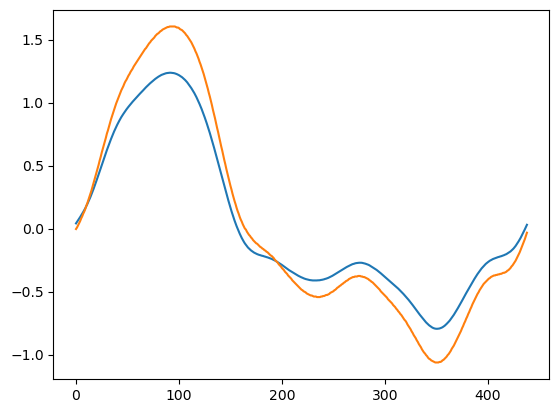

In [8]:
plt.plot(*X[1][X_mask[1].squeeze(),:].T)

In [9]:
ldf.to_csv("./dataset/y.csv")
np.save("./dataset/X.npy",X)
np.save("./dataset/X_mask.npy",X_mask)